<a href="https://colab.research.google.com/github/isabellacadisco/I-hate-you-P7-/blob/main/P7_textsent_databrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install transformers datasets evaluate accelerate

%pip install shap

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
dbutils.library.restartPython()

In [ ]:
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
import evaluate

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
from transformers.utils import logging
from transformers import EarlyStoppingCallback
from transformers import pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from copy import deepcopy
import shap

2024-05-11 17:24:41.734191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 17:24:41.734283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 17:24:42.077474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 17:24:42.774909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
path_en = '/dbfs/mnt/tesi/hs/final_labels.csv'

data_en = load_dataset("csv", data_files=path_en)

The cache_dir for this dataset is /root/.cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/']
During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
data_en = data_en.remove_columns(['entry_id', 'link_id', 'parent_id', 'entry_utc', 'subreddit', 'author', 'image', 'label_date', 'week', 'group', 'sheet_order', 'level_2', 'level_3', 'strength', 'highlight'])

In [ ]:
len(data_en['train'])

6567

train, validation, test split

In [ ]:
val_test = data_en.filter(lambda example: example['split'] == 'test').remove_columns(['split'])['train'].train_test_split(test_size=0.5, seed=42)

Filter:   0%|          | 0/6567 [00:00<?, ? examples/s]

In [ ]:
ds = DatasetDict({
    'train': data_en.filter(lambda example: example['split'] == 'train').remove_columns(['split'])['train'],
    'validation': val_test['train'],
    'test' : val_test['test']

})

Filter:   0%|          | 0/6567 [00:00<?, ? examples/s]

In [ ]:
ds = ds.rename_column("level_1", "label")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['body', 'label'],
        num_rows: 5264
    })
    validation: Dataset({
        features: ['body', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['body', 'label'],
        num_rows: 652
    })
})

remove null rows

In [ ]:
def remove_none_rows(example):
    return example["body"] is not None

ds = ds.filter(remove_none_rows)

Filter:   0%|          | 0/5264 [00:00<?, ? examples/s]

Filter:   0%|          | 0/651 [00:00<?, ? examples/s]

Filter:   0%|          | 0/652 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['body', 'label'],
        num_rows: 5254
    })
    validation: Dataset({
        features: ['body', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['body', 'label'],
        num_rows: 650
    })
})

distilbert fine tuning with learning rate from HPO google colab

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['body'], truncation=True, padding='max_length', max_length=512)

In [ ]:
tokenized = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/5254 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/650 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

print(accuracy.description)
print(f1.description)
print(precision.description)
print(recall.description)


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative


The F1 score is the harmonic mean of the precision and recall. It can be computed with the equation:
F1 = 2 * (precision * recall) / (precision + recall)


Precision is the fraction of correctly labeled positive examples out of all of the examples that were labeled as positive. It is computed via the equation:
Precision = TP / (TP + FP)
where TP is the True positives (i.e. the examples correctly labeled as positive) and FP is the False positive examples (i.e. the examples incorrectly labeled as positive).


Recall is the fraction of the positive examples that were correctly labeled by the model as positive. It can be computed with the equation:
Recall = TP / (TP + FN)
Where TP is the true positives and FN is the false negatives.



In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # compute
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_value = f1.compute(predictions=predictions, references=labels)
    precision_value = precision.compute(predictions=predictions, references=labels)
    recall_value = recall.compute(predictions=predictions, references=labels)

    # return metrics as dict
    return {
        "accuracy": accuracy_value['accuracy'],
        "f1": f1_value['f1'],
        "precision": precision_value['precision'],
        "recall": recall_value['recall']
    }


In [ ]:
id2label = {0: "Nonmisogynistic", 1: "Misogynistic"}
label2id = {"Nonmisogynistic": 0, "Misogynistic": 1}

early stopping

In [ ]:
logger = logging.get_logger(__name__)

In [ ]:
class Custom_EarlyStoppingCallback(EarlyStoppingCallback):

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        metric_to_check = args.metric_for_best_model
        if not metric_to_check.startswith("eval_"):
            metric_to_check = f"eval_{metric_to_check}"
        metric_value = metrics.get(metric_to_check)

        if metric_value is None:
            logger.warning(
                f"early stopping required metric_for_best_model, but did not find {metric_to_check} so early stopping"
                " is disabled"
            )
            return

        self.check_metric_value(args, state, control, metric_value)
        if self.early_stopping_patience_counter >= self.early_stopping_patience:
            print('EARLY STOPPING CALLED!')
            control.should_training_stop = True

In [ ]:
# convert labels from string to 0,1
def convert_labels(example):
    example['label'] = label2id[example['label']]
    return example

converted = tokenized.map(convert_labels)


Map:   0%|          | 0/5254 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/650 [00:00<?, ? examples/s]

train model adding weight decay since overfitting

In [ ]:
args_best = TrainingArguments(
    output_dir="/dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det/best_colab_model",

    num_train_epochs=12,
    weight_decay = 0.01,
    learning_rate = 1.5e-5,

    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model = 'eval_recall', # bavoid FN
    load_best_model_at_end=True,
    push_to_hub=False,

    logging_first_step=True,
    fp16=True,
    auto_find_batch_size=True,
)


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_best = Trainer(
    model=model,
    args=args_best,
    train_dataset=converted['train'],
    eval_dataset=converted['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks = [Custom_EarlyStoppingCallback(early_stopping_patience=2,
                                              early_stopping_threshold=0.01)]
)

In [ ]:
train_best_results = trainer_best.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
[W reducer.cpp:1346] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())


EARLY STOPPING CALLED!


In [ ]:
trainer_best.save_model('/dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det/best_colab_model/model')

In [ ]:
trainer_best.evaluate()

EARLY STOPPING CALLED!


{'eval_loss': 0.31536054611206055,
 'eval_accuracy': 0.9370199692780338,
 'eval_f1': 0.594059405940594,
 'eval_precision': 0.8333333333333334,
 'eval_recall': 0.46153846153846156,
 'eval_runtime': 10.336,
 'eval_samples_per_second': 62.983,
 'eval_steps_per_second': 7.933,
 'epoch': 4.0}

In [ ]:
predictions = trainer_best.predict(converted['test'])

In [ ]:
predicted_labels = np.argmax(predictions.predictions, axis=1)
ground_truth_labels = predictions.label_ids

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def print_confusion_matrix(predictions, labels):

    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-misogynistic", "Misogynistic"],
                yticklabels=["Non-misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


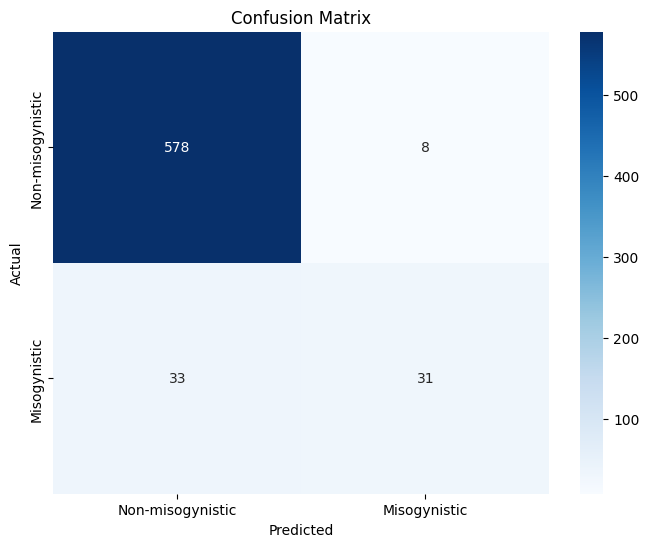

In [ ]:
print_confusion_matrix(predicted_labels, ground_truth_labels)

In [ ]:
def print_confusion_matrix_normalize(predictions, labels):

    cm = confusion_matrix(labels, predictions, normalize="true")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Non-misogynistic", "Misogynistic"],
                yticklabels=["Non-misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


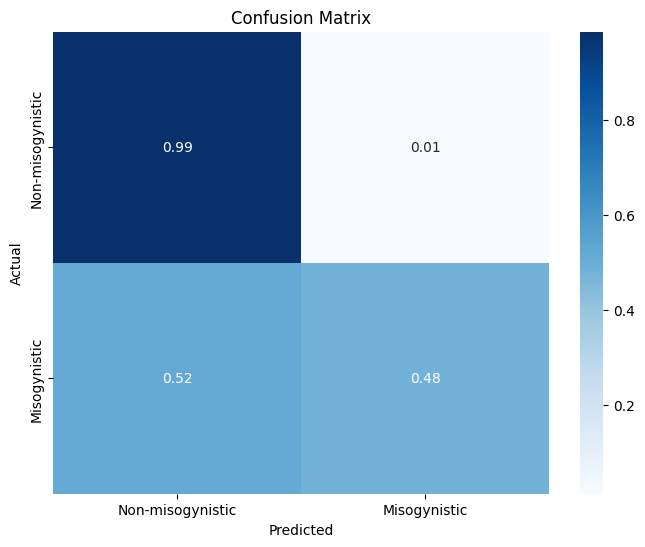

In [ ]:
print_confusion_matrix_normalize(predicted_labels, ground_truth_labels)

SHAP EXPLANATION of the examples classified as MISOGYNISTIC
whether they truly are or not

In [ ]:
torch.cuda.empty_cache()

In [ ]:
best_model = AutoModelForSequenceClassification.from_pretrained('/dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det/best_colab_model/model',
    id2label=id2label,
    label2id=label2id,).cuda()

In [ ]:
# build a pipeline object to do predictions
pred = pipeline(
    "text-classification",
    model=best_model,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)

In [ ]:
explainer = shap.Explainer(pred)

extract indices of examples classified as misogynistic

In [ ]:
data = ds['test']
data = data.rename_column("body", "text")
data

Dataset({
    features: ['text', 'label'],
    num_rows: 650
})

In [ ]:
# put text in lower case
data = data.map(lambda example: {'text': example['text'].lower(), 'label': example['label']})


In [ ]:
# indices of examples predicted misogynistic
indices = np.where(predicted_labels == 1)[0]

In [ ]:
data_pred_mis = data.select(indices)

In [ ]:
data_pred_mis

Dataset({
    features: ['text', 'label'],
    num_rows: 39
})

In [ ]:
# get indices of text <= 512 tokens
def f(x):
    tokenized_texts = [
        tokenizer.encode(v, max_length=512, truncation=True) if len(v) <= 512 else []
        for v in x
    ]

    valid_indices = [i for i, tokens in enumerate(tokenized_texts) if tokens]
    return valid_indices

In [ ]:
valid_indices = f(data_pred_mis['text'])

In [ ]:
data_valid = data_pred_mis.select(valid_indices)

In [ ]:
data_valid

Dataset({
    features: ['text', 'label'],
    num_rows: 30
})

In [ ]:
data_shap = data_valid[:]

In [ ]:
type(data_shap)

dict

In [ ]:
len(data_shap['text'])

30

In [ ]:
shap_values = explainer(data_shap['text'][:])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 31it [00:57,  2.32s/it]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


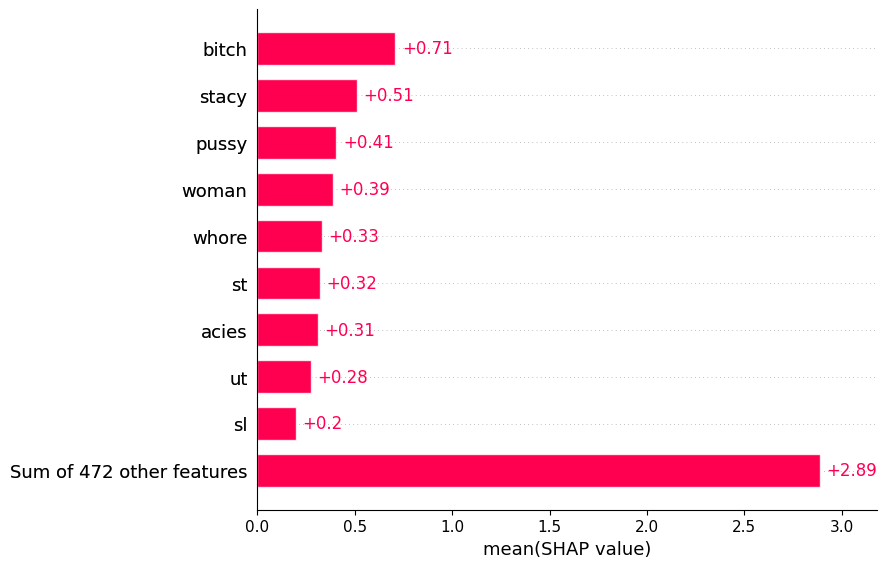

In [ ]:
shap.plots.bar(shap_values[:, :, "Misogynistic"].mean(0))

In [ ]:
shap.plots.text(shap_values[:, :, "Misogynistic"])